<H3>Wczytwanie i przetwarzanie obrazów za pomocą biblioteki OpenCV</H3>

Importowanie potrzebnych bibliotek

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import cv2
import math

ModuleNotFoundError: No module named 'cv2'

Wczytwanie danych

In [2]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader)
        # loop over all images in current annotations file
        for row in gtReader:
            x1,y1,x2,y2 = map(int,row[3:7])
            images.append(np.array(plt.imread(prefix + row[0]))[y1:y2,x1:x2]) # the 1th column is the filename
            labels.append(int(row[7])) # the 8th column is the label
        gtFile.close()
    return np.array(images), np.array(labels)

Wczytanie danych z folderu

In [3]:
path = r"..\GTSRB\Final_Training\Images"
images, labels = readTrafficSigns(path)

Wybranie jednego przykładu do analizy

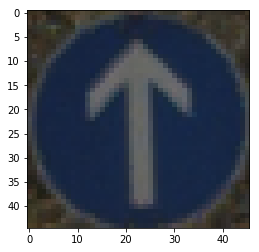

In [4]:
img_nr = 35000
plt.figure()
plt.imshow(images[img_nr])
plt.show()

Wyświetlanie obrazu za pomocą OpenCV. Zamknięcie okna przez naciśnięcie dowolnego klawisza.

In [5]:
cv2.imshow("Sign",images[img_nr])
cv2.waitKey(0)
cv2.destroyAllWindows()

Wyświetlanie powiększonego obrazu.

In [6]:
width, height, channels = np.shape(images[img_nr])
img_resized = cv2.resize(images[img_nr], (width*5, height*5))
cv2.imshow("Sign", img_resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

OpenCV przechowuje obrazy w formie macierzy pikseli, z których każdy zawiera trzy wartości kolorów BGR.<br>
Należy więc zmienić format zapisu danych z RGB do BGR.

In [7]:
img_bgr = cv2.cvtColor(img_resized,cv2.COLOR_RGB2BGR)

In [8]:
cv2.imshow("Sign BGR", img_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
img_gray = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2GRAY)

In [10]:
cv2.imshow("Sign gray", img_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

<H4>Hitogram obrazu czarno-białego</H4>

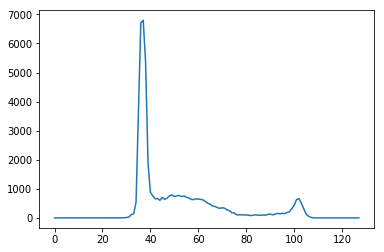

In [11]:
histr = cv2.calcHist([img_gray],[0],None,[128],[0,128])
plt.plot(histr)
plt.show()

<H4>Hitogram obrazu kolorowego</H4>

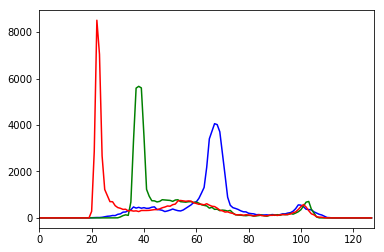

In [12]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img_bgr],[i],None,[128],[0,128])
    plt.plot(histr,color = col)
    plt.xlim([0,128])
plt.show()

<H2>HOG descriptor - Histogram of Oriented Gradients</H2>

Wczytujemy i zmiejszamy przykładowy obraz

In [13]:
test = cv2.imread('./test.jpg')
width, height, channels = np.shape(test)
width, height = width//2, height//2
test = cv2.resize(test, ( height, width) )

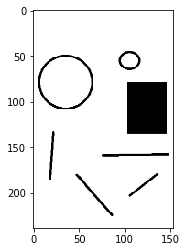

In [14]:
plt.imshow(test)

Za pomocą operatora Sobela wykrywane są krawędzie - gradienty

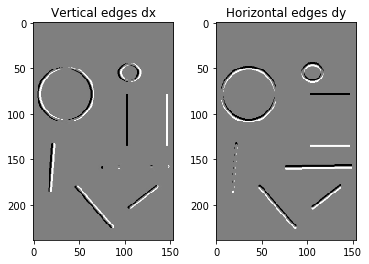

In [15]:
test_f = np.float32(test) / 255.0
 
# Calculate gradient 
gx = cv2.Sobel(test_f, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(test_f, cv2.CV_32F, 0, 1, ksize=1)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow((gx+1)/2.)
ax1.set_title("Vertical edges dx")

ax2.imshow((gy+1)/2.)
ax2.set_title("Horizontal edges dy")
plt.show()

Zmiana współrzędnych z kartezjańskich na polarne.<br>
$ g = \sqrt{g_x^2+g_y^2} \\
\theta = arctan(\frac{g_y}{g_x}) $

Text(0.5, 1.0, 'Magnitude of gradient')

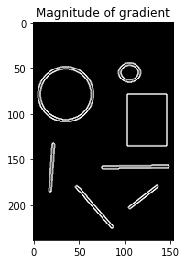

In [16]:
magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
plt.imshow(magnitude/np.max(magnitude))
plt.title("Magnitude of gradient")

Następny krok to podział obrazu na komórki o rozmiarze 8x8, w takiej komórce spodziewamy się objąć dyskryminatywną cechę. Rozmiar powinien zależeć od rozdzielczości obrazka i rodzaju cech jakich szukamy. Każdą komórkę opiszemy za pomocą 9 liczb, zamiast 128.

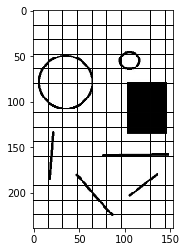

In [17]:
cellSize=16
test_cells=np.copy(test)
for x in range(1, width//cellSize+1):
    test_cells[x*cellSize,:]=1
for y in range(1, height//cellSize+1):
    test_cells[:,y*cellSize]=1
plt.imshow(test_cells)

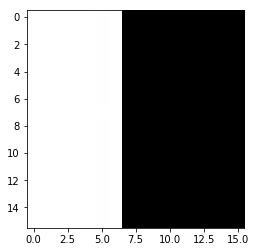

In [18]:
x=6
y=7
plt.imshow(test[y*cellSize:(y+1)*cellSize, x*cellSize:(x+1)*cellSize])

Dla każdej komórki liczony jest histogram gradientów. Histogram ma nbins przedziałów, z których każdy odpowiada kątom. Każdy piksel dla którego był obliczony gradient głosuje na odpowiedni kąt z wykorzystaniem wielkości tego gradientu. Na przykład analizując parę wartości: kąt = 5, wielkość = 20. Zwiększyć należy wartości w przedziałach o indeksie 0 i 1, w proporcjach 1:3, czyli przedział 0 zostanie zwiększony o 5, a przedział 1 o 15.


|Indeks| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 
|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
| Kąt | 0 | 20 | 40 | 60 | 80 | 100 | 120 | 140 | 160 | 



[//]: # (| Zakres | 170 - 10 |10 - 30 |30 - 50 |50 - 70 |70 - 90 |90 - 110 |110 - 130 |130 - 150 |150 - 170 |)



In [19]:
def getHOGforCell(cell_magnitude, cell_angle, nbins=9):
    result = np.zeros((nbins))
    bin_size=180/nbins
    
    for mag, ang in zip(np.reshape(cell_magnitude,(-1,1)), np.reshape(cell_angle,(-1,1)) ):
        bin_idx=ang/180.*9
        l_bin = int(bin_idx)
        r_bin = math.ceil(bin_idx)

        if l_bin==nbins:
            l_bin=0
        if r_bin==nbins:
            r_bin=0
            
        ratio = bin_idx - l_bin
        
        result[l_bin] += mag*ratio
        result[r_bin] += mag*(1-ratio)  
    return result

Wizualizacja histogramu dla jednej komórki.

([<matplotlib.axis.XTick at 0x1336ec9cd68>,
 <a list of 9 Text xticklabel objects>)

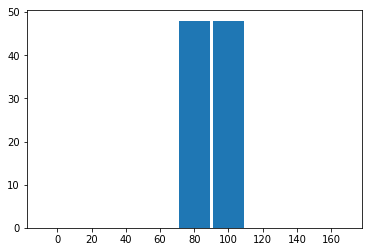

In [20]:
hist = getHOGforCell(magnitude[y*cellSize:(y+1)*cellSize, x*cellSize:(x+1)*cellSize], 
                         angle[y*cellSize:(y+1)*cellSize, x*cellSize:(x+1)*cellSize]/2.)
plt.figure()
plt.bar(np.arange(0,180,20), hist, width=18)
plt.xticks(np.arange(0,180,20))

Obliczenie histogramów gradientów dla wszystkich komorek w obrazie.

In [21]:
HOG = np.zeros(((height//cellSize),(width//cellSize),9))
for x in range(height//cellSize):
    for y in range(width//cellSize):
        HOG[x,y] = getHOGforCell(magnitude[y*cellSize:(y+1)*cellSize, x*cellSize:(x+1)*cellSize], 
                                 angle[y*cellSize:(y+1)*cellSize, x*cellSize:(x+1)*cellSize]/2.)

In [22]:
def displayHOG(img, HOG):
    width, height, channels = np.shape(img)
    plt.imshow(test_cells)
    colors = ('y','yellow','orange','r','darkviolet','b','c','g','lime')

    for x in range(height//cellSize):
        for y in range(width//cellSize):
            mx = x * cellSize + cellSize/2;
            my = y * cellSize + cellSize/2;

            for i in range(9):
                gradientMagnitude = HOG[x,y,i]

                gradientAngle = i * np.pi/9. + np.pi/2

                X = gradientMagnitude * np.cos(gradientAngle)
                Y = gradientMagnitude * np.sin(gradientAngle)    

                scale = 0.05

                x1 = mx - X * scale
                y1 = my - Y * scale
                x2 = mx + X * scale
                y2 = my + Y * scale

                plt.plot([x1,x2], [y1,y2],c=colors[i])

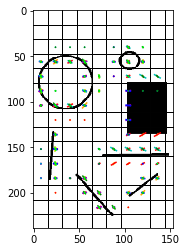

In [23]:
displayHOG(test_cells, HOG)

W cely zminimalizowania wpływu jasności obrazu na gradienty wykonywana jest normalizacja.

In [ ]:
def normalizeHOG(HOG, blockSize):
    width, height, channels = np.shape(HOG)
    result = np.zeros(np.shape(HOG))
    for x in range(width//blockSize[1]):
        for y in range(height//blockSize[0]):
            xb =     x*blockSize[0]
            xe = (x+1)*blockSize[0]
            yb =     y*blockSize[1]
            ye = (y+1)*blockSize[1]
            vector_len = np.linalg.norm(HOG[ xb:xe, yb:ye])
            
            if vector_len!=0:
                result[xb:xe, yb:ye] = HOG[xb:xe, yb:ye]/vector_len *100

    return result

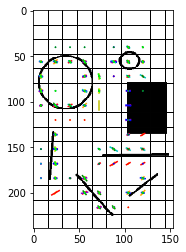

In [ ]:
HOG_normalized = normalizeHOG(HOG, (2,2))
displayHOG(test_cells, HOG_normalized)

<H2>Analiza obrazu dłoni</H2>

Wczytywanie za pomocą opencv

In [ ]:
h1 = cv2.imread('./1.jpg')
width, height, channels = np.shape(h1)
width, height

(3640, 2720)

In [ ]:
cv2.imshow("hand1",  cv2.resize(h1, (300, 400)) )
cv2.waitKey(5000)
cv2.destroyAllWindows()

Wybranie obszarów o interesującym nas kolorze

In [ ]:
#zmiana przestrzeni kolorów z BGR do HSV
h1_hsv = cv2.cvtColor(h1, cv2.COLOR_BGR2HSV)

#określenie zakresu kolorów, które nas interesują (w przestrzeni HSV)
lower = np.array([120,30,30])
upper = np.array([160,255,255])

#Progowanie obrazu za pomocą zdefiniowanych zakresów
h1_mask = cv2.inRange(h1_hsv, lower, upper)
    
cv2.imshow("hand1",  cv2.resize(h1_mask, (300, 400)) )
cv2.waitKey(5000)
cv2.destroyAllWindows()

Dokumentacja:
https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html

In [ ]:
contours, hierarchy = cv2.findContours(h1_mask, cv2.RETR_TREE , cv2.CHAIN_APPROX_NONE)
print(np.shape(contours))

h1_contours = np.copy(h1)

cv2.drawContours(h1_contours, contours, -1, (0,0,255), 20, hierarchy=hierarchy, maxLevel = 2)
cv2.drawContours(h1_contours, contours, -1, (0,255,0), 20, hierarchy=hierarchy, maxLevel = 1)

cv2.imshow("Contours", cv2.resize(h1_contours, (300, 400)))
cv2.waitKey(5000)
cv2.destroyAllWindows()

(36,)


In [ ]:
print(len(contours))

36


In [ ]:
h1_contours = np.copy(h1)

cv2.drawContours(h1_contours, contours, 0, (0,255,0), 20, hierarchy=hierarchy, maxLevel = 0)
cv2.drawContours(h1_contours, contours, 1, (255,255,255), 20, hierarchy=hierarchy, maxLevel = 0)
cv2.drawContours(h1_contours, contours, 2, (0,0,255), 20, hierarchy=hierarchy, maxLevel = 0)

cv2.imshow("Contours", cv2.resize(h1_contours, (300, 400)))
cv2.waitKey(5000)
cv2.destroyAllWindows()

In [ ]:
for c in contours:
    print(len(c))

In [ ]:
long_contours = [c for c in contours if len(c)>100]
for c in long_contours:
    print(len(c))

In [ ]:
h1_contours = np.copy(h1)

cv2.drawContours(h1_contours, long_contours, 0, (0,255,0), 20, hierarchy=hierarchy, maxLevel = 0)
cv2.drawContours(h1_contours, long_contours, 1, (255,0,0), 20, hierarchy=hierarchy, maxLevel = 0)
cv2.drawContours(h1_contours, long_contours, 2, (0,0,255), 20, hierarchy=hierarchy, maxLevel = 0)

cv2.imshow("Contours", cv2.resize(h1_contours, (300, 400)))
cv2.waitKey(5000)
cv2.destroyAllWindows()

Obliczanie pola konturu

In [ ]:
cv2.contourArea(long_contours[0])

Obliczanie obwodu konturu

In [ ]:
cv2.arcLength(long_contours[0],True)#drugi parametr wskazuje na to czy kontur jest zamknięty czy nie

Wielokąt wypukły zawierający kontur

In [ ]:
#zmiana obrazu z kolorowego na czarno-biały
h1_gray = cv2.cvtColor(h1,cv2.COLOR_BGR2GRAY)

convex_hull = cv2.convexHull(long_contours[0])

h1_convex_hull = np.zeros_like(h1) 
 
cv2.drawContours(h1_convex_hull, long_contours, 0, (255, 0, 0), 20)
cv2.drawContours(h1_convex_hull, [convex_hull], 0, (0, 0, 255), 20)

cv2.imshow("Convex Hull", cv2.resize(h1_convex_hull, (300, 400)))
cv2.waitKey(5000)
cv2.destroyAllWindows()

Wycięcie ręki z obrazka

In [ ]:
#Utworzenie maski, gdzie biały - 255 oznacza fragmenty, które chcemy zostawić, a czarny - 0 te których się pozbedziemy
mask = np.zeros_like(h1_gray) 
cv2.drawContours(mask, long_contours, 0, 255, -1)

cv2.imshow('Mask', cv2.resize(mask, (300, 400)))
cv2.waitKey(0)
cv2.destroyAllWindows()

#przepisujemy na pustą tablicę te wartości pixeli gdzie maska jest równa 255
h1_extracted = np.zeros_like(h1_gray) 
h1_extracted[mask == 255] = h1_gray[mask == 255]

cv2.imshow('Output', cv2.resize(h1_extracted, (300, 400)))
cv2.waitKey(0)
cv2.destroyAllWindows()

Obliczanie momentu

$ M_{ij} = \sum _{x}^{}  \sum _{y}^{} x^iy^jI(x,y) $

Najprostrzy moment $M_{00}$ 

$ M_{00} = \sum _{x}^{}  \sum _{y}^{} I(x,y) $

In [ ]:
M = cv2.moments(h1_extracted)
M

Obliczanie geometrycznego środka za pomocą momentów

In [ ]:
(M["m10"]/M["m00"], M["m01"]/M["m00"])

In [ ]:
HM = cv2.HuMoments(M)
HM

Momenty Hu w skali logarytmicznej

$ H_{i} = -log|h_i| $

In [ ]:
HM_log = [-math.log(abs(hm)) for hm in HM]
HM_log

In [ ]:
%matplotlib auto